<a href="https://colab.research.google.com/github/harshit110927/Zelestra-Hackathon/blob/main/zelestraxaws.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')
submission = pd.read_csv("/content/drive/MyDrive/dataset/sample_submission.csv")

In [4]:
print(train.shape)
print(test.shape)
train.info()
train.describe()
train.head()

(20000, 17)
(12000, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   temperature         18999 non-null  float64
 2   irradiance          19013 non-null  float64
 3   humidity            20000 non-null  object 
 4   panel_age           18989 non-null  float64
 5   maintenance_count   18973 non-null  float64
 6   soiling_ratio       18990 non-null  float64
 7   voltage             19007 non-null  float64
 8   current             19023 non-null  float64
 9   module_temperature  19022 non-null  float64
 10  cloud_coverage      18990 non-null  float64
 11  wind_speed          20000 non-null  object 
 12  pressure            20000 non-null  object 
 13  string_id           20000 non-null  object 
 14  error_code          14088 non-null  object 
 15  installation_type   14972 non

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
0,0,7.817315,576.179270,41.24308670850264,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,62.494044,12.82491203459621,1018.8665053152533,A1,NaN,NaN,0.562096
1,1,24.785727,240.003973,1.3596482765960705,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,43.851238,12.012043660984917,1025.6238537572883,D4,E00,dual-axis,0.396447
2,2,46.652695,687.612799,91.26536837560256,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,NaN,1.814399755560454,1010.9226539809573,C3,E00,NaN,0.573776
3,3,53.339567,735.141179,96.19095521176159,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,67.361473,8.736258932034128,1021.8466633134253,A1,NaN,dual-axis,0.629009
4,4,5.575374,12.241203,27.495073003585226,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,3.632000,0.52268384077164,1008.5559577591927,B2,E00,fixed,0.341874


# Now as we have loaded the data set and have had a basic understanding of How the data looks, we begin with EDA ( Exploratory Data Analysis) to better understand how each features better relates to the target (efficiency) and also inter-feature relations.

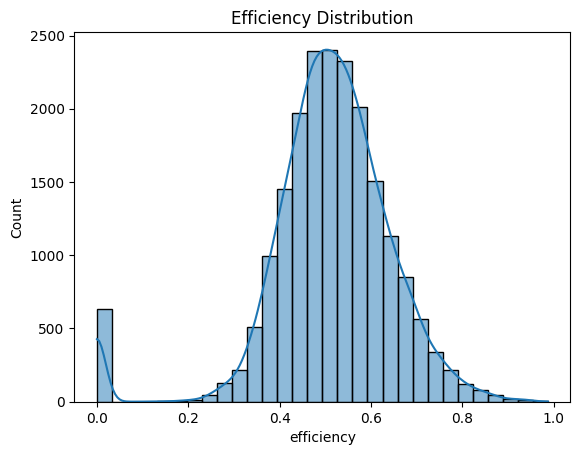

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

sns.histplot(train['efficiency'], kde=True, bins=30)
plt.title("Efficiency Distribution")
plt.show()

The efficiency is Normally Distributed

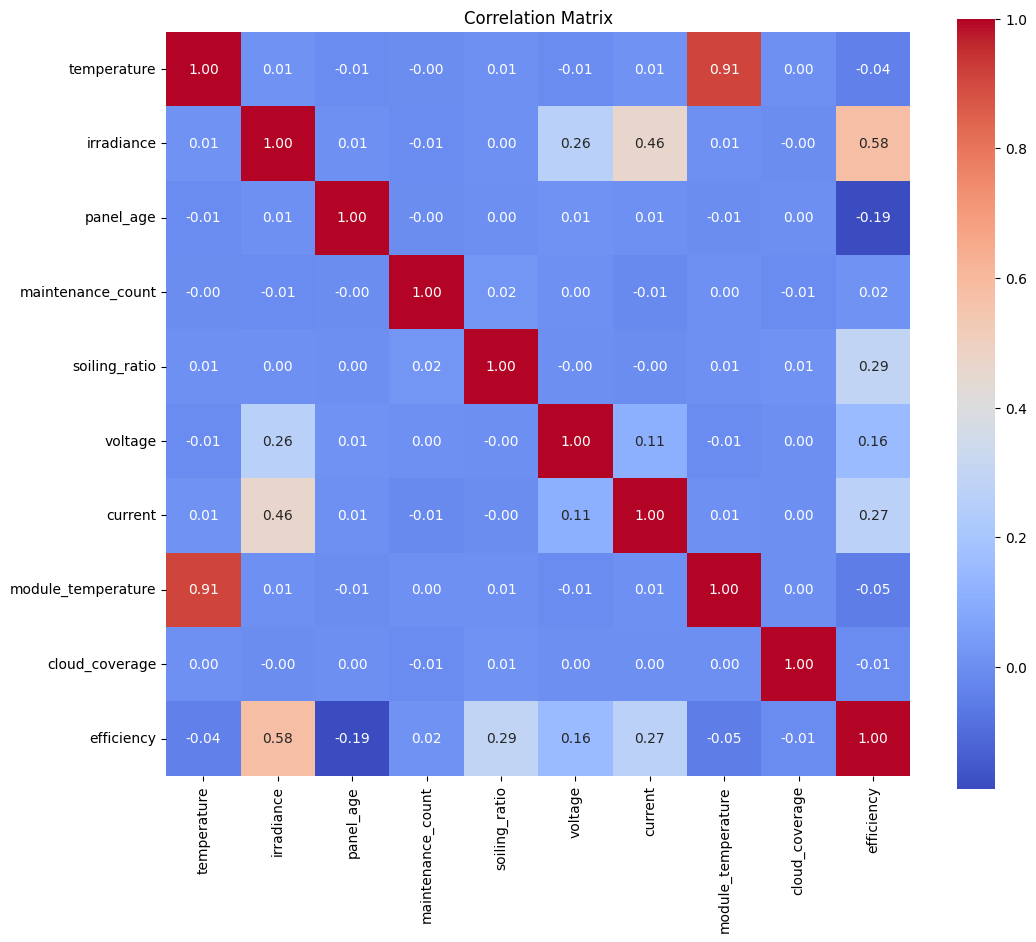

In [6]:
numerical_features = train.select_dtypes(include=['float64', 'int64']).drop(columns=['id']).columns

plt.figure(figsize=(12, 10))
corr = train[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()


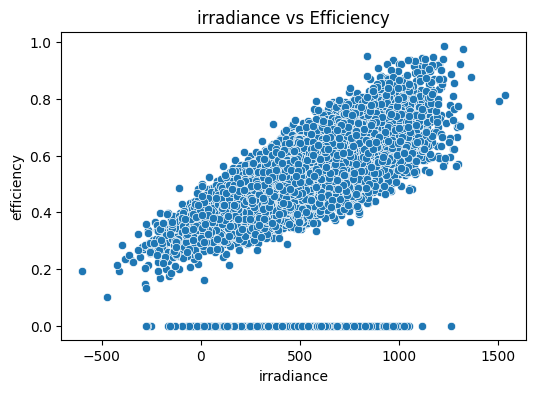

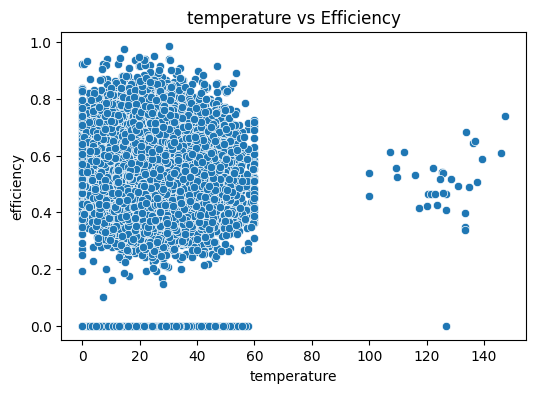

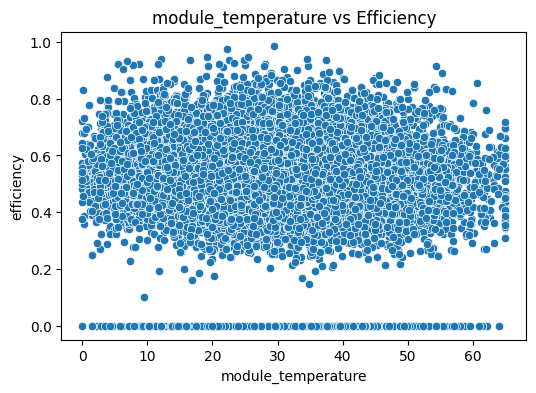

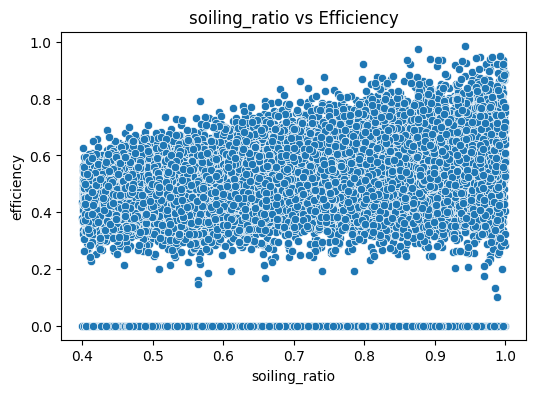

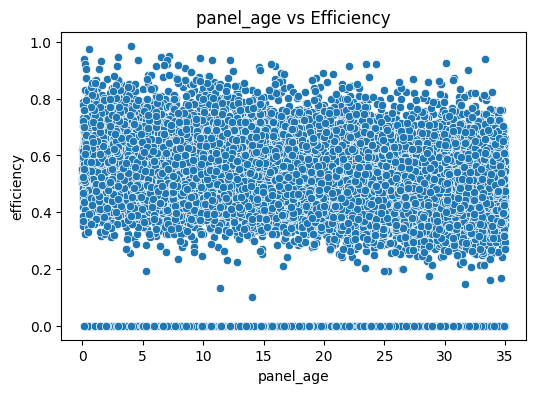

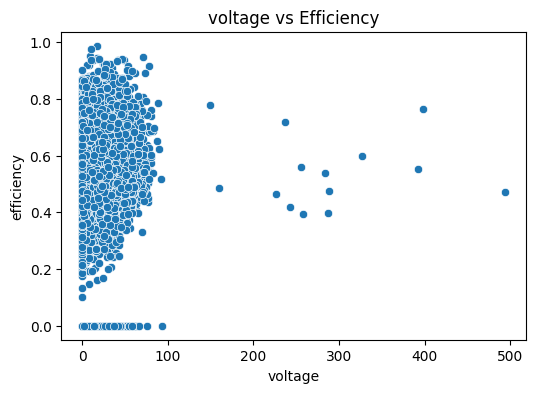

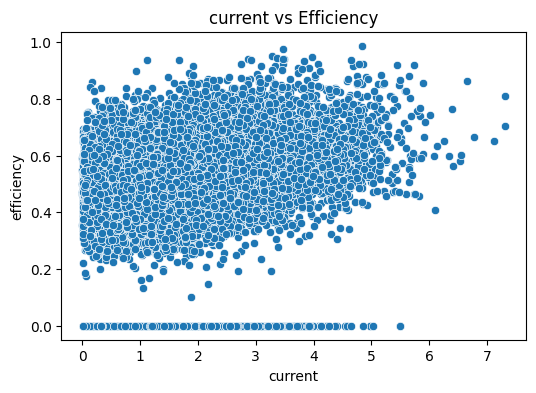

In [10]:
important_features = ['irradiance', 'temperature', 'module_temperature', 'soiling_ratio', 'panel_age', 'voltage', 'current']

for feature in important_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=train, x=feature, y='efficiency')
    plt.title(f"{feature} vs Efficiency")
    plt.show()


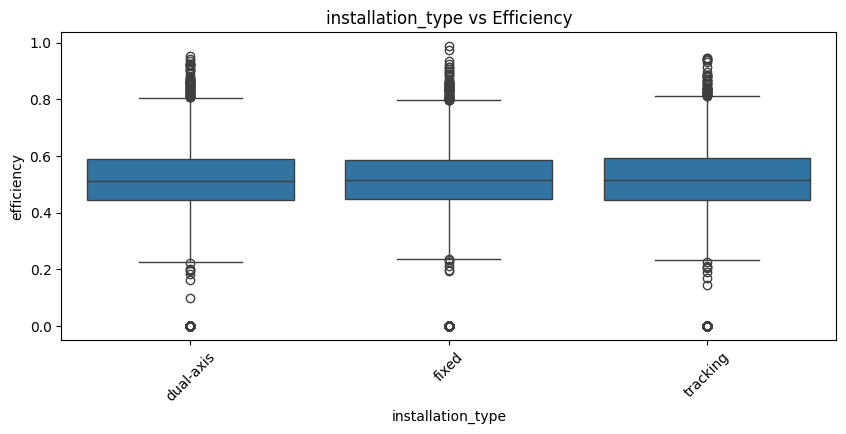

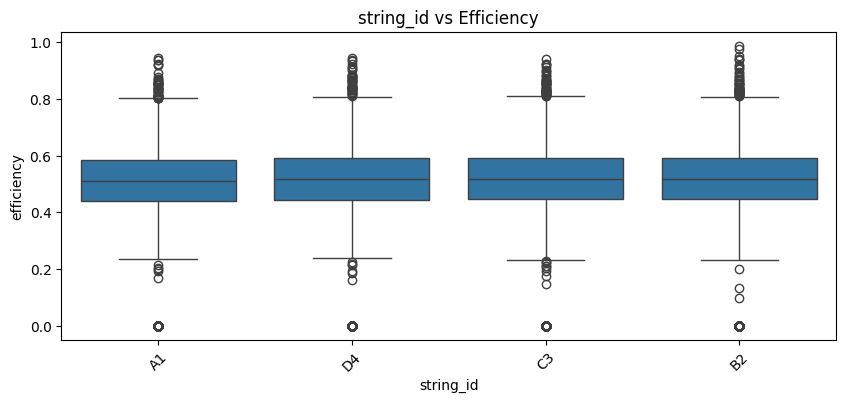

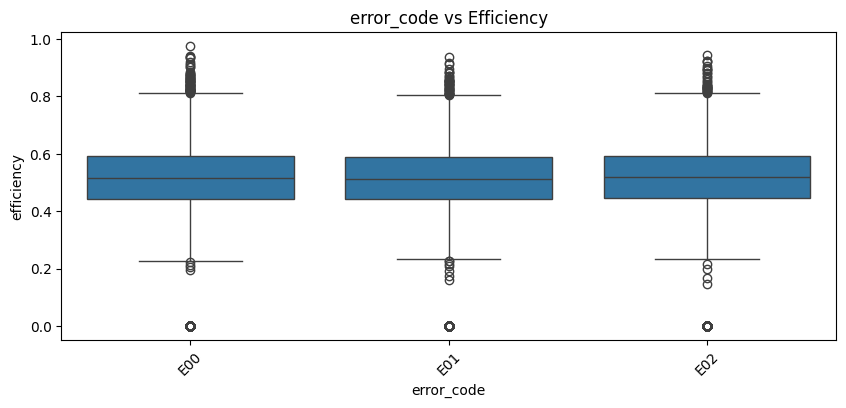

In [11]:
cat_features = ['installation_type', 'string_id', 'error_code']

for cat in cat_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=train, x=cat, y='efficiency')
    plt.xticks(rotation=45)
    plt.title(f"{cat} vs Efficiency")
    plt.show()


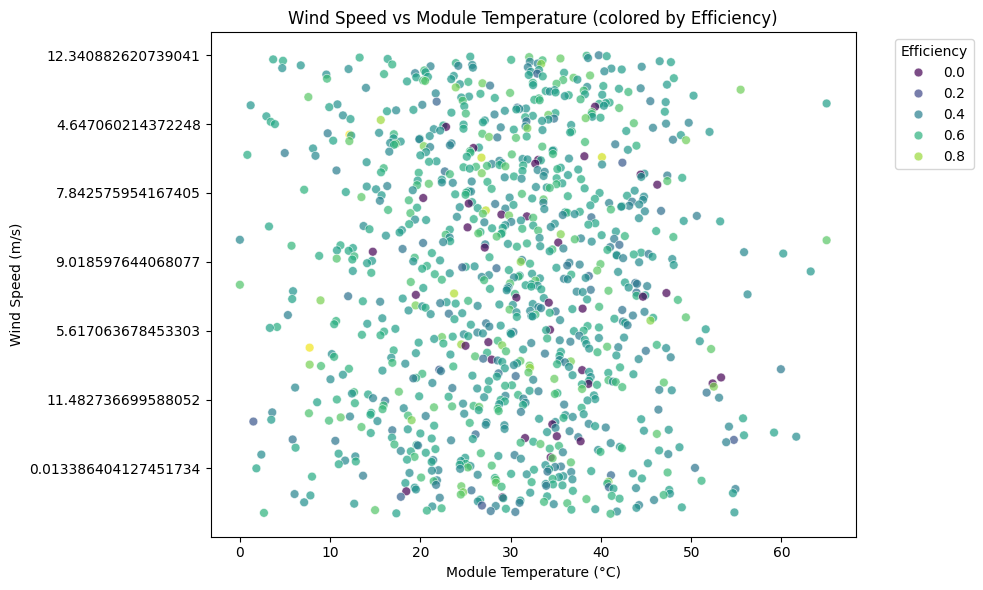

In [15]:
sample = train.sample(1000, random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=sample['module_temperature'],
    y=sample['wind_speed'],
    hue=sample['efficiency'],
    palette='viridis',
    s=40,
    alpha=0.7
)
plt.title("Wind Speed vs Module Temperature (colored by Efficiency)")

# Set readable y-axis
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  # reduce y-axis ticks
plt.yticks(rotation=0)  # Keep them horizontal

plt.xlabel("Module Temperature (°C)")
plt.ylabel("Wind Speed (m/s)")
plt.legend(title="Efficiency", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

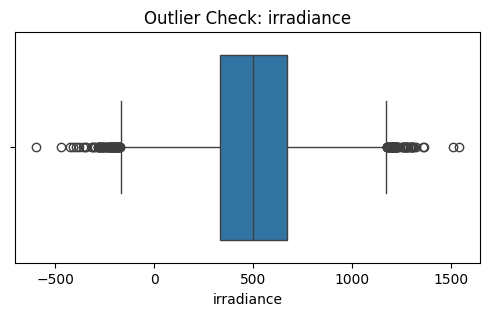

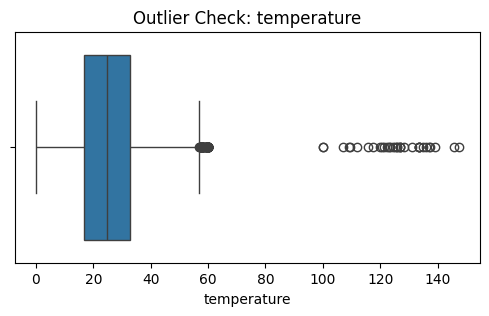

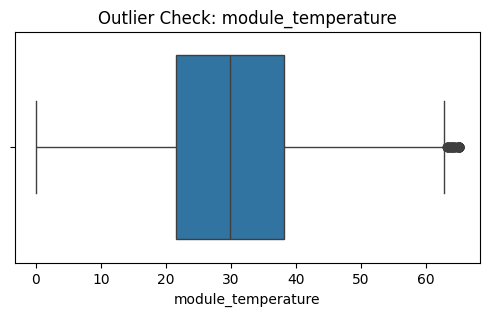

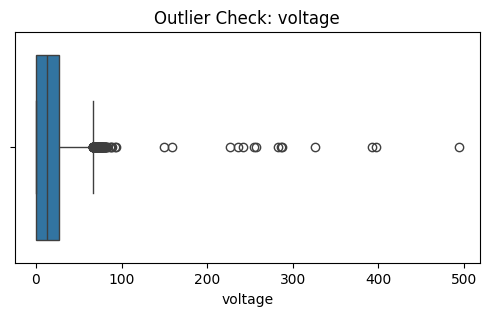

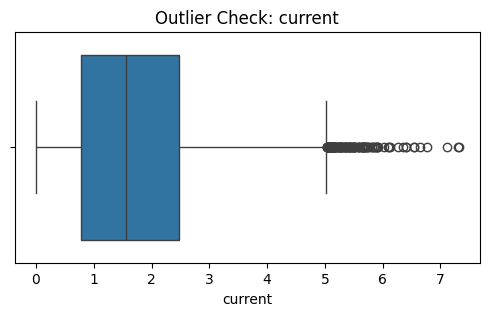

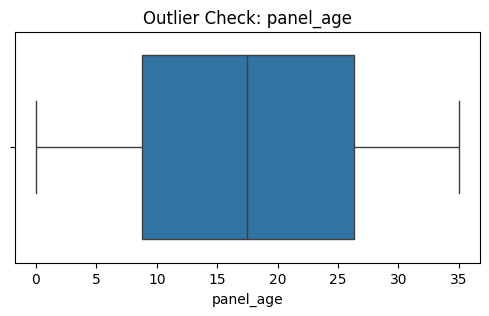

In [17]:
for feature in ['irradiance', 'temperature', 'module_temperature', 'voltage', 'current', 'panel_age']:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=train[feature])
    plt.title(f"Outlier Check: {feature}")
    plt.show()


In [28]:
# Create new domain-logical features
train['power'] = train['voltage'] * train['current']
train['temp_diff'] = train['module_temperature'] - train['temperature']
train['irradiance_per_temp'] = train['irradiance'] / (train['module_temperature'] + 1e-3)  # avoid divide-by-zero
train['is_high_wind'] = (train['wind_speed'] > str(5)).astype(int)  # Threshold can be tuned


In [29]:
from sklearn.preprocessing import LabelEncoder

# Frequency encoding for string_id and error_code
for col in ['string_id', 'error_code']:
    freq_encoding = train[col].value_counts(normalize=True)
    train[f'{col}_freq'] = train[col].map(freq_encoding)

# Target encoding
target_means = train.groupby('string_id')['efficiency'].mean()
train['string_id_target_enc'] = train['string_id'].map(target_means)


KeyError: 'string_id'

In [26]:
# Drop one of the highly correlated features
import numpy as np
# Keep only numeric columns
numeric_cols = train.select_dtypes(include=[np.number]).columns

corr_matrix = train[numeric_cols].corr().abs()
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
train_reduced = train.drop(columns=to_drop)
